In [1]:
import os,sys
import numpy as np
import xarray as xr
%matplotlib inline

from utils import *

path_out = './seamount/'

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


---

### load data

In [2]:
# default directories
romsdir = '/home/datawork-lops-osi/jgula/SEAMOUNT/Config_croco_SW_N_KPP0_HR_U/case1/'
outdir = './roms_in/'

ds = xr.open_dataset(romsdir+'caldeira_his.00000.nc')

ds = fix_coords(ds)
print(ds)

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 402, eta_v: 401, s_rho: 50, s_w: 51, time: 1000, xi_rho: 402, xi_u: 401)
Coordinates:
  * s_rho       (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w         (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
    x_rho       (eta_rho, xi_rho) float32 ...
    y_rho       (eta_rho, xi_rho) float32 ...
  * time        (time) float32 0.0 100000.0 200000.0 ... 99800000.0 99900000.0
  * eta_rho     (eta_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
  * eta_v       (eta_v) float32 0.0 1000.0 2000.0 ... 398000.0 399000.0 400000.0
  * xi_rho      (xi_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
  * xi_u        (xi_u) float32 0.0 1000.0 2000.0 ... 398000.0 399000.0 400000.0
Dimensions without coordinates: auxil
Data variables:
    spherical   |S1 ...
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 ...
    sc_w        (s_w) f

In [3]:
# time index is also added to the suffix
#it=5
it=100
#it=15
I = slice(250,350)
J = slice(100,250)
K = slice(2,None)

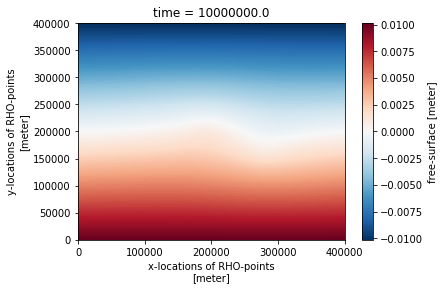

In [4]:
ds.zeta.isel(time=it).plot()

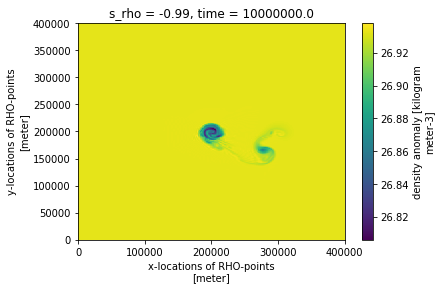

In [5]:
ds.rho.isel(time=it, s_rho=0).plot()
#ds.rho.isel(time=100, s_rho=0).plot(x='x_rho', y='y_rho')

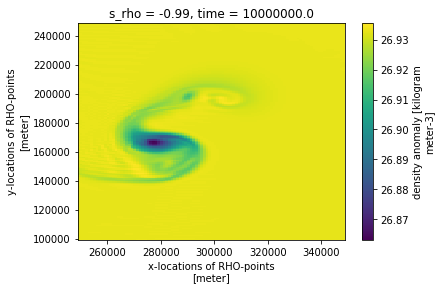

In [6]:
ds.rho.isel(time=it, s_rho=0, xi_rho=I, eta_rho=J).plot()

---

### start defining a background state

<xarray.DataArray 'zeta' (eta_rho: 402, xi_rho: 402)>
array([[ 0.003402,  0.003402,  0.003402, ...,  0.003402,  0.003402,  0.003402],
       [ 0.010172,  0.010172,  0.010172, ...,  0.010172,  0.010172,  0.010172],
       [ 0.010121,  0.010121,  0.010121, ...,  0.010121,  0.010121,  0.010121],
       ...,
       [-0.010117, -0.010117, -0.010117, ..., -0.010117, -0.010117, -0.010117],
       [-0.010168, -0.010168, -0.010168, ..., -0.010168, -0.010168, -0.010168],
       [-0.003402, -0.003402, -0.003402, ..., -0.003402, -0.003402, -0.003402]],
      dtype=float32)
Coordinates:
    y_rho    (eta_rho, xi_rho) float32 -500.0 -500.0 ... 400500.0 400500.0
    time     float32 10000000.0
  * eta_rho  (eta_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
  * xi_rho   (xi_rho) float32 -500.0 500.0 1500.0 ... 398500.0 399500.0 400500.0


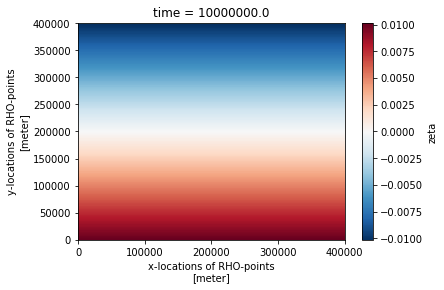

In [7]:
#ds.zeta.isel(xi_rho=0,time=slice(500,600)).plot()

# spatially uniform background
#zeta_bg = ds.zeta.isel(time=it,xi_rho=0).mean('eta_rho')+0.*ds.zeta.isel(time=it)
#rho_bg_sigma = ds.rho.isel(time=it,xi_rho=0).mean('eta_rho')+0.*ds.rho.isel(time=it)

# background state includes y variations
zeta_bg = ds.zeta.isel(time=it,xi_rho=0)+0.*ds.zeta.isel(time=it)
rho_bg_sigma = ds.rho.isel(time=it,xi_rho=0)+0.*ds.rho.isel(time=it)

print(zeta_bg)
zeta_bg.plot()

---

### horizontal/verticals grid and metric terms

In [8]:
# horizontal grid
print('process horizontal grid')

x = ds.xi_rho.rename('x')
y = ds.eta_rho.rename('y')

grd = xr.merge([x, y])

#dxt = ds.x_rho.diff('xi_rho').rename('dxt')
#dyt = ds.y_rho.diff('eta_rho').rename('dyt')
# could also use pm, pn, ...
dxt = 1./ds.pm.rename('dxt')
dyt = 1./ds.pn.rename('dyt')

grd = xr.merge([dxt, dyt, 
                dxt.rename('dxu'), dyt.rename('dyu'),
                dxt.rename('dxv'), dyt.rename('dyv')])

print(grd)

process horizontal grid
<xarray.Dataset>
Dimensions:  (eta_rho: 402, xi_rho: 402)
Coordinates:
    x_rho    (eta_rho, xi_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
    y_rho    (eta_rho, xi_rho) float32 -500.0 -500.0 ... 400500.0 400500.0
  * eta_rho  (eta_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
  * xi_rho   (xi_rho) float32 -500.0 500.0 1500.0 ... 398500.0 399500.0 400500.0
Data variables:
    dxt      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyt      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dxu      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyu      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dxv      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyv      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994


In [9]:
# vertical grid
print('process vertical grid')
zr0 = get_z(ds, zeta=zeta_bg.max(), h=ds.h.max())
zw0 = get_z(ds, zeta=zeta_bg.max(), h=ds.h.max(), vgrid='w')
grd = grd.assign_coords(z_r=zr0.rename({'s_rho':'z_r'}))
grd = grd.assign_coords(z_w=zw0.isel(s_w=slice(1,None)).rename({'s_w':'z_w'}))

# not xarray like ...
zt, zw = grd.z_r.values, grd.z_w.values
dzt = np.hstack((zw[0]-zt[0],np.diff(zw)))
dzw = np.hstack((np.diff(zt),zw[-1]-zt[-1]))
#
grd['dzt'] = xr.DataArray(dzt, coords={'z_r': grd.z_r}, dims={'z_r': grd.z_r}, name='dzt')
grd['dzw'] = xr.DataArray(dzw, coords={'z_w': grd.z_w}, dims={'z_w': grd.z_w}, name='dzw')

print(grd)

process vertical grid
<xarray.Dataset>
Dimensions:  (eta_rho: 402, xi_rho: 402, z_r: 50, z_w: 50)
Coordinates:
    x_rho    (eta_rho, xi_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
    y_rho    (eta_rho, xi_rho) float32 -500.0 -500.0 ... 400500.0 400500.0
  * eta_rho  (eta_rho) float32 -500.0 500.0 1500.0 ... 399500.0 400500.0
  * xi_rho   (xi_rho) float32 -500.0 500.0 1500.0 ... 398500.0 399500.0 400500.0
    time     float32 10000000.0
  * z_r      (z_r) float64 -99.76 -99.24 -98.66 ... -1.293 -0.5691 -0.1148
  * z_w      (z_w) float64 -99.5 -98.96 -98.36 -97.7 ... -0.8977 -0.308 0.01017
Data variables:
    dxt      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyt      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dxu      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyu      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dxv      (eta_rho, xi_rho) float32 999.99994 999.99994 ... 999.99994
    dyv    

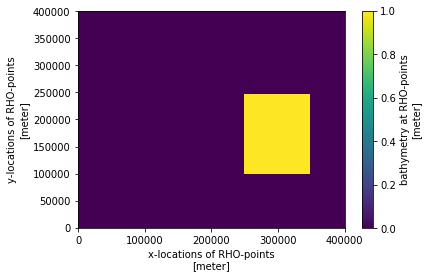

In [10]:
# mask
mask = xr.ones_like(ds.h)
mask = (mask.where(mask.xi_rho>mask.xi_rho[I.start], other=0.)
            .where(mask.xi_rho<mask.xi_rho[I.stop-1], other=0.)
            .where(mask.eta_rho>mask.eta_rho[J.start], other=0.)
            .where(mask.eta_rho<mask.eta_rho[J.stop-1], other=0.)
       )
mask.plot()
grd['mask']=mask

In [11]:
# store
grd['lon'] = 0.*grd.dxt + grd.xi_rho # order matter here for dimension right order
grd['lat'] = 0.*grd.dxt + grd.eta_rho 
(grd.rename({'xi_rho': 'x','eta_rho': 'y', 'z_r': 'zt', 'z_w': 'zw'})
 .isel(x=I,y=J,zt=K,zw=K).to_netcdf(path_out+'roms_metrics.nc', mode='w'))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


---

### compute 3D pressure

In [12]:
state = ds.isel(time=it)
#print(state)

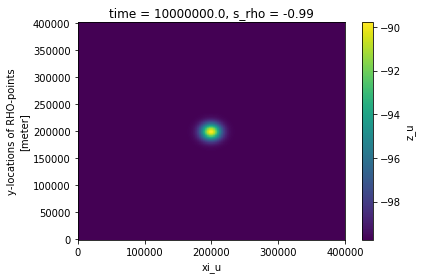

In [13]:
z_r = get_z(state)
z_u = get_z(state, hgrid='u').rename('z_u')
z_v = get_z(state, hgrid='v').rename('z_v')
#state = state.assign_coords(z_r=z_r, z_u=z_u, z_v=z_v)

z_u.isel(s_rho=0).plot()

In [14]:
rho_bg = rho_bg_sigma.rename({'s_rho':'z_r'}).assign_coords(z_r=grd.z_r)
rho = interp2z_xr(grd.z_r, z_r, state.rho).rename('rho')
u = interp2z_xr(grd.z_r, z_u, state.u, hgrid='u').rename('u')
v = interp2z_xr(grd.z_r, z_v, state.v, hgrid='v').rename('v')

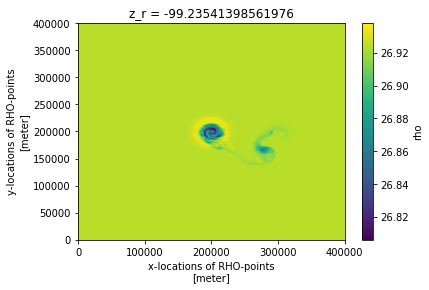

In [15]:
rho.isel(z_r=1).plot()

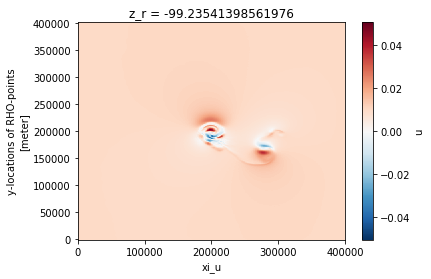

In [16]:
u.isel(z_r=1).plot()

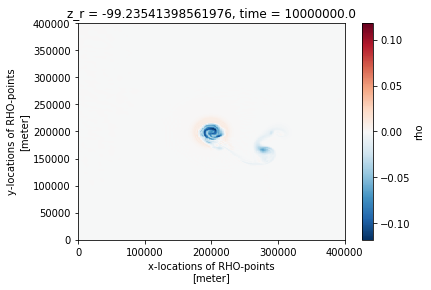

In [17]:
# compute density reference profile and take it away from the 3D density
rho_a = rho_bg.mean(['xi_rho','eta_rho'])
rho_bg = rho_bg - rho_a
rho = rho - rho_a

rho.isel(z_r=1).plot()

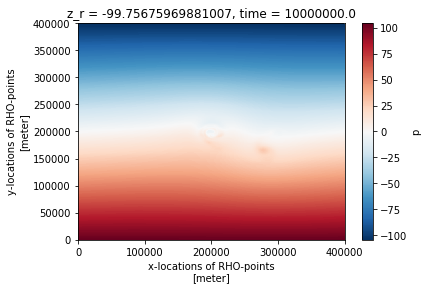

In [18]:
p = get_p(rho, state.zeta, state.rho0, rho_a)
p.isel(z_r=0).plot()

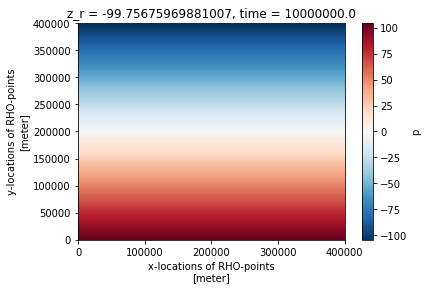

In [19]:
p_bg = get_p(rho_bg, zeta_bg, state.rho0, rho_a)
p_bg.isel(z_r=0).plot()

---
### compute and store psi and density

In [20]:
# psi
f0 = state.f.mean(['xi_rho','eta_rho']).rename('f0')
rho0 = state.rho0

psi = (p/f0/rho0).rename('psi')
psi_bg = (p_bg/f0/rho0).rename('psi_bg')

(psi.to_dataset().rename({'xi_rho': 'x','eta_rho': 'y', 'z_r': 'zt'})
 .isel(x=I,y=J,zt=K).to_netcdf(path_out+'roms_psi.nc'))

In [21]:
# density
(rho.to_dataset().rename({'xi_rho': 'x','eta_rho': 'y', 'z_r': 'zt'})
 .isel(x=I,y=J,zt=K).to_netcdf(path_out+'roms_rho.nc'))

---

### compute and store N2 and PV

In [22]:
# N2
N2 = -g*rho_a.diff('z_r')/rho0/rho_a.z_r.diff('z_r')
N2 = N2.rename('N2') #{'z_r': 'z_w'}
N2 = N2.rename({'z_r': 'z_w'}).assign_coords(z_w=grd.z_w.isel(z_w=slice(1,None)))
print(N2)

<xarray.DataArray 'N2' (z_w: 49)>
array([0.000165, 0.000165, 0.000166, 0.000167, 0.000167, 0.000168, 0.000169,
       0.00017 , 0.000171, 0.000172, 0.000173, 0.000174, 0.000175, 0.000177,
       0.000178, 0.00018 , 0.000182, 0.000184, 0.000186, 0.000188, 0.00019 ,
       0.000192, 0.000194, 0.000197, 0.000199, 0.000202, 0.000205, 0.000207,
       0.00021 , 0.000213, 0.000215, 0.000218, 0.000221, 0.000223, 0.000226,
       0.000229, 0.000231, 0.000233, 0.000236, 0.000238, 0.00024 , 0.000241,
       0.000243, 0.000244, 0.000246, 0.000247, 0.000248, 0.000248, 0.000249])
Coordinates:
  * z_w      (z_w) float64 -98.96 -98.36 -97.7 -96.97 ... -0.8977 -0.308 0.01017
    time     float32 10000000.0


In [23]:
# PV
q = get_pv(u, v, rho, rho_a, state.f, f0, grd.z_r, grd.z_w,state)
u_bg, v_bg = get_uv_from_psi(psi_bg, state)
u_bg, v_bg = rho2u(u_bg, state), rho2v(v_bg, state)
q_pv = get_pv(u_bg, v_bg, rho_bg, rho_a, state.f, f0, grd.z_r, grd.z_w,state)

In [24]:
# store
ds_q = xr.merge([N2, state.f, f0, q])
(ds_q.rename({'xi_rho': 'x','eta_rho': 'y', 'z_r': 'zt', 'z_w': 'zw'})
 .isel(x=I,y=J,zt=K).to_netcdf(path_out+'roms_pv.nc'))

---

### store background values

In [26]:
# background rho, psi, q
ds_bg = xr.merge([rho_bg, psi_bg, q_pv])
(ds_bg.rename({'xi_rho': 'x','eta_rho': 'y', 'z_r': 'zt', 'psi_bg': 'psi'})
 .isel(x=I,y=J,zt=K).to_netcdf(path_out+'roms_bg.nc'))